#### 諸々の動作確認用

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from sklearn.metrics import accuracy_score
from keras.models import load_model
from keras.preprocessing.image import load_img
from tqdm import tqdm

sys.path.append('..')
from src import Utils

loadpkl = Utils.loadpkl
save2pkl =Utils.save2pkl

predict_result = Utils.predict_result
IMG_SIZE_TARGET = Utils.IMG_SIZE_TARGET
my_iou_metric = Utils.my_iou_metric

%matplotlib inline

In [30]:
train_df = loadpkl('../output/train_df.pkl')
test_df = loadpkl('../output/test_df.pkl')

In [31]:
train_df.head()

,z,images,masks,coverage,coverage_class,is_salt,binary_pred
id,,,,,,,
575d24d81d,843,"[[0.525490196078, 0.513725490196, 0.5254901960...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,0,0,0.000095
a266a2a9df,794,"[[0.341176470588, 0.376470588235, 0.3333333333...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.504950,6,1,0.988288
75efad62c1,468,"[[0.56862745098, 0.466666666667, 0.32549019607...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.993334,10,1,0.999449
34e51dba6a,727,"[[0.541176470588, 0.474509803922, 0.3960784313...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.149201,2,1,0.558364
4875705fb0,797,"[[0.0666666666667, 0.078431372549, 0.090196078...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.042839,1,1,0.000016


In [32]:
test_df.head()

,z,binary_pred,is_salt
id,,,
353e010b7b,264,0.000583,False
5439dbbddf,557,0.350468,False
71bab9f311,846,0.001427,False
52551f7a80,610,0.152591,False
512d8d9997,577,0.999000,True


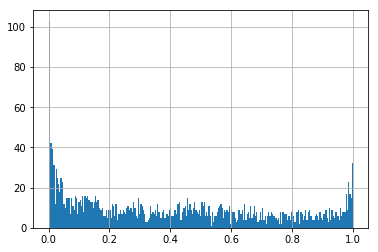

In [5]:
train_df.coverage[train_df.coverage>0.0].hist(bins=255)

In [21]:
x_test = np.array([(np.array(load_img("../input/test/images/{}.png".format(idx), color_mode = "grayscale"))) / 255 for idx in tqdm(test_df.index)]).reshape(-1, 101, 101, 1)

100%|██████████| 18000/18000 [00:07<00:00, 2467.80it/s]


In [5]:
model = load_model('../output/unet_best_bin0.model', custom_objects={'my_iou_metric': my_iou_metric})

In [4]:
from keras.applications.resnet50 import ResNet50

In [7]:
model_resnet = ResNet50(include_top=False, weights='imagenet')

/home/fujiwara/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [9]:
for layer in model_resnet.layers:
    layer.traiable=False

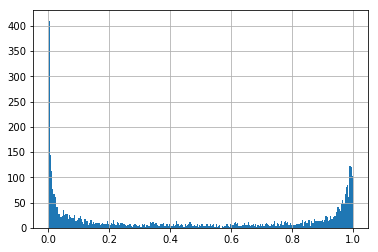

In [21]:
train_df.binary_pred.hist(bins=255)

In [33]:
acc_best = 0.0
for th in np.arange(0, 1.00001, 0.0001):
    _pred = train_df.binary_pred.apply(lambda x: 1 if x > th else 0)
    _acc = accuracy_score(train_df.is_salt, _pred)
    if _acc > acc_best:
        acc_best = _acc
        best_threshold = th
        print("threshold: {:.4f}, acc: {:.10f}".format(th, _acc))
print("best threshold: {:.4f}, best acc: {:.10f}".format(best_threshold, acc_best))

threshold: 0.0000, acc: 0.6095000000
threshold: 0.0001, acc: 0.6842500000
threshold: 0.0002, acc: 0.7027500000
threshold: 0.0003, acc: 0.7087500000
threshold: 0.0004, acc: 0.7152500000
threshold: 0.0005, acc: 0.7187500000
threshold: 0.0006, acc: 0.7270000000
threshold: 0.0007, acc: 0.7370000000
threshold: 0.0008, acc: 0.7397500000
threshold: 0.0009, acc: 0.7442500000
threshold: 0.0010, acc: 0.7450000000
threshold: 0.0011, acc: 0.7480000000
threshold: 0.0012, acc: 0.7492500000
threshold: 0.0013, acc: 0.7510000000
threshold: 0.0014, acc: 0.7522500000
threshold: 0.0015, acc: 0.7540000000
threshold: 0.0016, acc: 0.7557500000
threshold: 0.0017, acc: 0.7605000000
threshold: 0.0018, acc: 0.7615000000
threshold: 0.0019, acc: 0.7625000000
threshold: 0.0020, acc: 0.7632500000
threshold: 0.0021, acc: 0.7645000000
threshold: 0.0022, acc: 0.7650000000
threshold: 0.0023, acc: 0.7662500000
threshold: 0.0024, acc: 0.7672500000
threshold: 0.0025, acc: 0.7692500000
threshold: 0.0026, acc: 0.7715000000
t

In [34]:
test_df.loc[:,'is_salt'] = test_df.is_salt>best_threshold

In [68]:
test_df.is_salt.value_counts() / len(test_df)

True     0.6075
False    0.3925
Name: is_salt, dtype: float64

In [38]:
save2pkl('../output/test_df.pkl', test_df)

In [62]:
sub = pd.read_csv('../output/submission_bst.csv', index_col=0)

In [63]:
sub[~test_df['is_salt']].loc[:,'rle_mask'] = np.nan

/home/fujiwara/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/home/fujiwara/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/pandas/core/indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [65]:
sub.to_csv('../output/submission_bes_filled_empty.csv')

In [64]:
sub

,rle_mask
id,
73eb0134c9,25 77 125 78 225 79 325 80 425 81 524 83 623 8...
cc4cb99e50,1 44 102 45 203 46 304 49 405 51 506 53 607 55...
2ebc0fb07c,NaN
de2ce9bf28,NaN
97e335754c,NaN
c157e34751,NaN
1056e892f6,3433 2 3533 3 3634 3 3734 4 3835 4 3935 5 4036...
5313788acb,80 22 180 23 281 23 382 23 483 23 583 24 684 2...
40e83640df,NaN
